<center>
    <h1> Extended Project Supplement</h1>
</center>

Interactive plots + animations corresponding to figures
- Code for all figures??
- Numerical Methods 
- Application to model
- Space homogeneity
- Space inhomogeneity
- Python .py file too?


In [1]:
import numpy as np
from numpy.random import normal, uniform
import scipy.stats as stats
from scipy.integrate import simps

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
cmap = plt.get_cmap('plasma')


from src import herding as herd
from src import SpaceHet as het
from src import SpaceHom as hom
from src import ToyProblems as TP
from src.plotting import hom_plot as homplt
from src.plotting import het_plot as hetplt

savepath = './Report/Figures/'
save = False

## Toy Problems

- Heat eqn, adv eqn
- Mesh refinement error
- OU particles

### Particle System with Langevin Dynamics


Outputs an animation of histogram of particles at each timestep. Along with the mean velocity and variance of all particles at each timestep.

In [11]:
%matplotlib qt
particle_count = 500
diffusion = 1
initial_data = normal(loc=0.5, scale=np.sqrt(2), size=particle_count)#uniform(low=0, high=1, size=particle_count)
timestep = 0.01
T_final = 30

animate = False
#If animation is too slow, increase framestep.
framestep = 1
###############################################################################
t, x, [m1, var] = TP.run_OU_process(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final)
ani = homplt.anim_hist_moments(t, x, m1, var, mu=0,
                              D=diffusion, fs=framestep, animate=animate)
plt.show()
fig, ax = plt.subplots()
ax.plot(x[:,0], x[:,0]**2/2, markeredgecolor='none')
fig.show()
# timesteps = np.logspace(0,-5, 10)
# error = np.zeros((2,len(timesteps)))
# avg_error = np.zeros((2,len(timesteps)))
# for i in range(10):
#     for idx, t in enumerate(timesteps):
#         t, x, [m1, var] = TP.run_OU_process(particles=particle_count,
#                        D=diffusion,
#                        initial_dist=initial_data,
#                        dt=t,
#                        T_end=T_final)
#         error[:,idx] = abs(m1[-1]), abs(var[-1]-1)
#         print('Round {}/{}  complete'.format(idx+1,len(timesteps)))
#     print('#'*20+'ROUND {} COMPLETE'.format(i))
#     avg_error += error
# avg_error /= 10

Plot histogram of positions and 5 sample paths

In [ ]:
fig, ax = plt.subplots()
ax.plot(timesteps, avg_error[0,], '*', label='Mean', c='red', markeredgecolor='none')
ax.plot(timesteps, avg_error[1,], '*',label='Variance', c='blue', markeredgecolor='none')
#ax.plot(timesteps, 10**(0.5*timesteps)-1, 'k--', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
plt.show()

### Heat Equation

Solving the heat equation using finite differences. To see the sensitivity of FTCS on mesh size, try violating the stability condition $\frac{\sigma \Delta t}{\Delta x}^2 < \frac{1}{2}$. For example, set `diffusion = 1, timestep = 0.01, spacestep = 0.1`

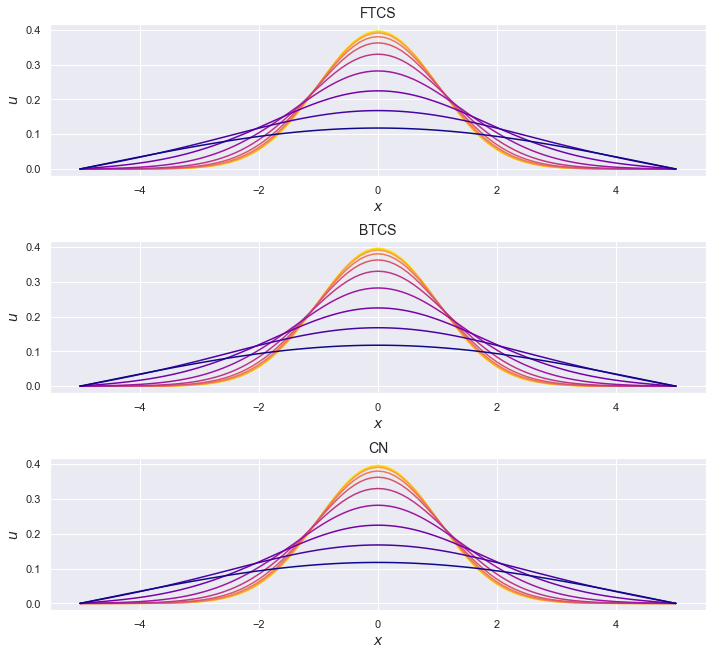

In [77]:
%matplotlib inline
diffusion = 1
timestep = 0.005
spacestep = 0.1
T_final = 5
domain_size = 5
def indicator(x): return np.array([int(i>=-1 and i<=0) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=0, scale=1)

initial_data = gaussian
diff_solvers = [TP.FTCS, TP.BTCS, TP.CN]

###############################################################################
fig, ax = plt.subplots(len(diff_solvers), 1, figsize=(10,10))
#fig.suptitle('Heat Equation in 1D', fontsize=16)

if len(diff_solvers)==1:
    ax = [ax]

for idx, solver in enumerate(diff_solvers):
    x, sol = TP.solve_heat_eqn(solver=solver, dt=timestep, dx=spacestep,
                            T_end=T_final, L=domain_size, initial_dist=initial_data)
    homplt.static_line(x, sol, solver, ax[idx])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

if save:
    plt.savefig(savepath+'{}.eps'.format(timestep), format='eps', dpi=1000)

### Advection Equation

Solving the advection equation using finite differences and finite volumes. Both methods are sensitive to mesh spacing. For example, set `wavespeed = 1, timestep = 0.21, spacestep = 0.1`. Also note the artificial dispersion introduced, regardless of spacing.

upwind mass loss was 0.00001%
FV_upwind mass loss was 0.00000%


C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


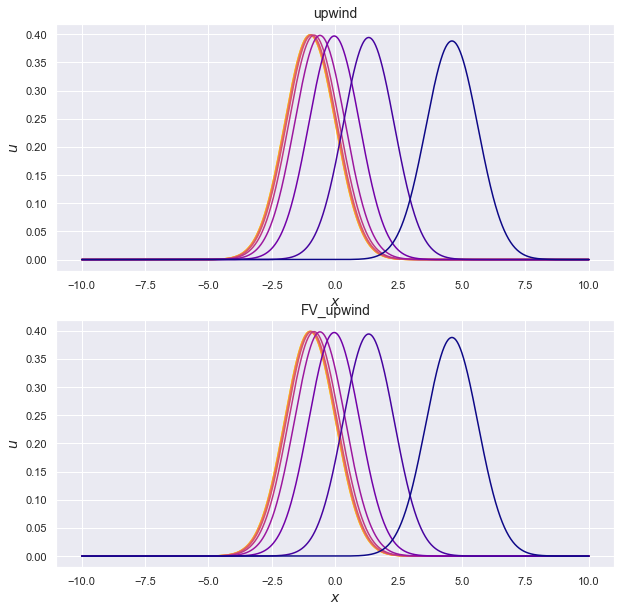

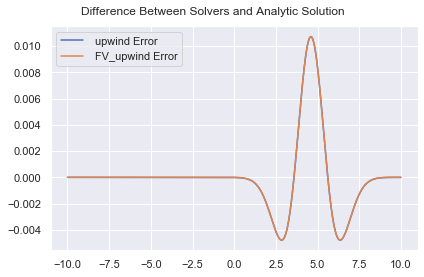

In [9]:
wavespeed = 0.2
T_final = 28
timestep = 0.01
spacestep = 0.012
domain_size = 10 
def indicator(x): return np.array([int(i>=-1 and i<=0) for i in x])
def gaussian(x): return stats.norm.pdf(x, loc=-1, scale=1)
initial_data = gaussian
adv_solvers = [TP.upwind, TP.FV_upwind]


###############################################################################
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig1,ax1= plt.subplots()

#fig.suptitle('Advection Equation in 1D', fontsize=16)
cmap = plt.get_cmap('plasma')
if len(adv_solvers)==1:
    ax = [ax]
for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = TP.solve_adv_eqn(solver=solver, a=wavespeed,
                                      dt=timestep, dx=spacestep,
                                      T_end=T_final, L=domain_size,
                                      initial_dist=initial_data)
    homplt.static_line(adv_x, adv_sol, solver, ax[idx])
    true_sol = gaussian(adv_x-wavespeed*T_final)
    ax1.plot(adv_x, true_sol - adv_sol[-1,], label=' {} Error'.format(solver.__name__))
    ax1.legend()

fig1.suptitle('Difference Between Solvers and Analytic Solution')
fig1.show()    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if save:
    plt.savefig(savepath+'adv'+initial_data.__name__+'.eps', format='eps', dpi=1000)

In [ ]:
%matplotlib inline
T_final = 100

###############################################################################
t, x, [m1, var] = TP.run_OU_process(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data,
                   dt=timestep,
                   T_end=T_final)

fig, ax = plt.subplots(1,2, figsize=(16,8))
n_x, bins_x, patches_x = ax[0].hist(x[-750:].flatten(),
                                    bins=np.arange(x.min(), x.max(), 0.15),
                                    density=True, label='Position')

mu = 0
D = 1
sigma = np.sqrt(D)
_x = np.arange(mu - 5*sigma, mu + 5*sigma, 0.01)
stat_dist = stats.norm.pdf(_x, mu, sigma)

ax[0].plot(_x, stat_dist, 'r--')
ax[0].set_xlabel('Position', fontsize=18)
ax[0].set_ylabel('Density', fontsize=18)
for _ in range(3):
    ax[1].plot(t[:500], x[:500,_], label='Particle {}'.format(_+1))
ax[1].set_xlabel('Time', fontsize=18)
ax[1].set_ylabel('Position', fontsize=18)
fig.show()
if save:
    fig.savefig(savepath+'OUparticletraj.eps', format='eps', dpi=1000)


# Space Homogeneous System

## Particle Model Simulation

OU process is same as space homogeneous with no interaction. Combine Interaction, histograms 


In [3]:
%matplotlib qt
particle_count = 1000
diffusion = 1
initial_data = indicator
timestep = 0.01
T_final = 30
herding_function = herd.smooth_G

framestep = 5
animate = True

t, v, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data['particle'],
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)

n, bins, patches = plt.hist(v[-500:].flatten(), bins=np.arange(v.min(), v.max(), 0.15),
                           density=True, label='Velocity')
stat_mu = np.sign(v[0,].mean())
stat_sigma = np.sqrt(diffusion)
_v = np.arange(stat_mu - 5*stat_sigma, stat_mu + 5*stat_sigma, 0.01)
stat_dist = stats.norm.pdf(_v, stat_mu, stat_sigma)

plt.plot(_v, stat_dist, '-.',label=r'Stationary D$^{\mathrm{n}}$')
plt.show()


ani = homplt.anim_hist_moments(t, v, M1, var, mu=stat_mu,
                               D=diffusion, fs=framestep, animate=animate, timeavg=True)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
import pandas as pd
import seaborn as sns
%matplotlib qt
particle_count = 1000
diffusion = 1
timestep = 0.01
T_final = 30
herding_function = herd.smooth_G

framestep = 5
animate = True

n = 500
t = np.arange(0, T_final+timestep, timestep)
mean = np.zeros((2,1))
#Set initial data for Gaussian
mu_init = -0.5
sd_init = 1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

initial_data = gaussian
for _ in range(n):
    t, v, [M1, var] = hom.run_particle_model(particles=particle_count,
                       D=diffusion,
                       initial_dist=initial_data['particle'],
                       dt=timestep,
                       T_end=T_final,
                       G=herding_function)
    mean = np.concatenate((mean, [M1,t[1:]]), axis=1)


mean = pd.DataFrame(mean.T)
mean = mean.rename(columns={0:'Particle', 1:'Time'})
mean = mean.drop(mean.index[0])
print(mean.head())
sns.lineplot(x="Time", y="Particle", data=mean)
mu_0 =  M1[0]
mean_ode = np.sign(mu_0) - np.sign(mu_0)*(-abs(mu_0) + 1)*np.exp(-0.5 * t)
plt.plot(t, mean_ode, 'r:')
plt.show()

   Particle  Time
1 -0.485963  0.01
2 -0.498182  0.02
3 -0.498161  0.03
4 -0.498692  0.04
5 -0.497592  0.05


If the system is ran for a long time with a low number of particles, we see switches in stability and convergence to a distribution with mean zero.

In [ ]:
%matplotlib qt
particle_count = 6
diffusion = 1
initial_data = indicator
timestep = 0.01
T_final = 500
herding_function = herd.smooth_G

framestep = 50
animate = True

t, v, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data['particle'],
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)
stat_mu = np.sign(v[0,].mean())
stat_sigma = np.sqrt(diffusion)
_v = np.arange(stat_mu - 5*stat_sigma, stat_mu + 5*stat_sigma, 0.01)
stat_dist = stats.norm.pdf(_v, stat_mu, stat_sigma)

ani = homplt.anim_hist_moments(t, v, M1, var, mu=stat_mu, D=diffusion,
                               fs=framestep, animate=animate, timeavg=True)
plt.show()

## Kinetic Model


- Long time L1 error, asymmetry
- FV method
- agreement in histogram, visual with FD
- symmetric error
- Mesh refinement errors

Use the function below to see the convergence in moments for the finite difference method compared to the particle system, as well as an animation (if `animate = True`) of the solution evolving in time.

Finite difference mass loss was 0.00%
Finite volume mass loss was 0.00%


C:\Users\s1415551\Documents\GitHub\Whales\src\plotting\hom_plot.py:111: UserWarning: Matplotlib is currently using Qt5Agg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


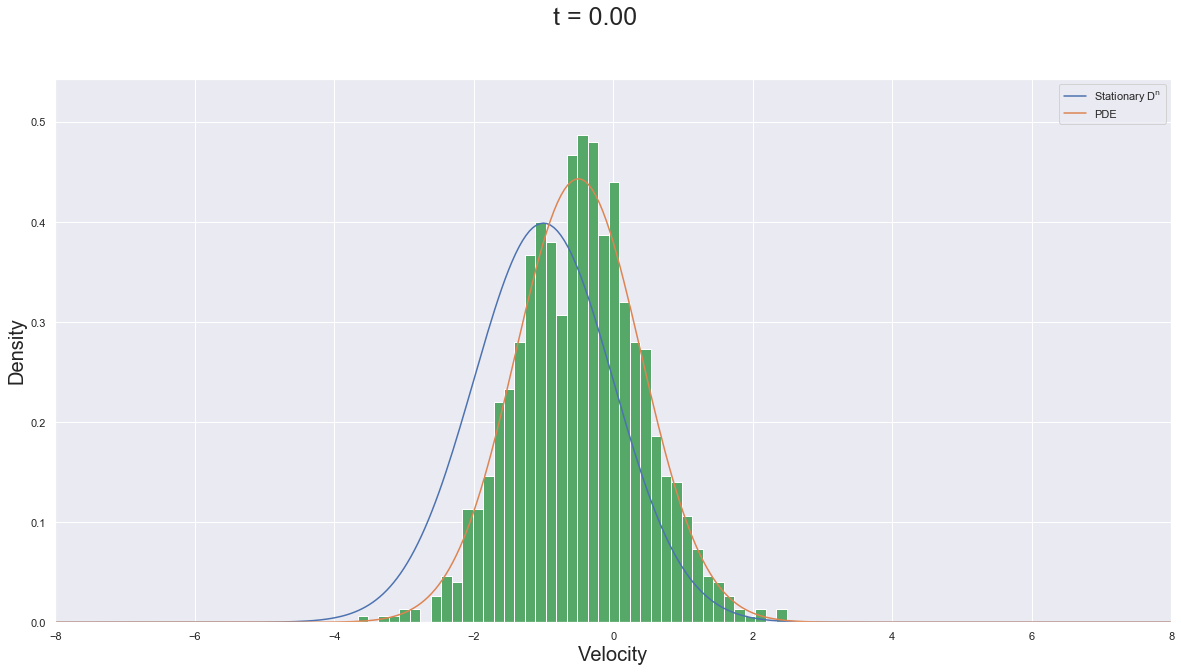

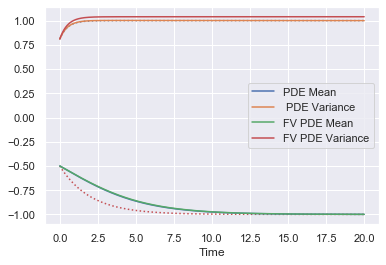

In [22]:
%matplotlib qt
diffusion = 1
particle_count = 1000
timestep = 0.001
T_final = 20
domain_size = 8
spacestep = 0.05

herding_function = herd.smooth_G
#Set initial data for Gaussian
mu_init = -0.5
sd_init = 0.9

#Set max/min for indicator
max_init = 0
min_init = -1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data = gaussian #Choose indicator or Gaussian

framestep = 10
animate = True

###############################################################################
v, F, moments = hom.FD_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)
FV_v, FV_F, FV_moments = hom.FV_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

t, traj, [M1, var] = hom.run_particle_model(particles=particle_count,
                   D=diffusion,
                   initial_dist=initial_data['particle'],
                   dt=timestep,
                   T_end=T_final,
                   G=herding_function)
if animate:
    ani = homplt.animate_PDE_hist(t, v, traj , F)
    plt.show()

fig,ax=plt.subplots()
#ax.plot(t[1:], M1, label='Particle Mean')
#ax.plot(t[1:], var, label='Particle Variance')
stat_mu = np.sign(F[0,].mean())
mu_0 =  moments[1][0] 
mean_ode = (mu_0+1)*np.exp(-0.5*t)-1 #np.sign(mu_0) - np.sign(mu_0)*(-abs(mu_0) + 1)*np.exp(-0.5 * t)
var_0 = moments[2][0]-moments[1][0]**2
var_ode = diffusion +(var_0-diffusion)*np.exp(-2*t)
ax.plot(t, mean_ode, 'r:')
ax.plot(t, var_ode, 'b:')
ax.plot(t[1:], moments[1], label='PDE Mean')
ax.plot(t[1:], moments[2]-moments[1]**2, label=' PDE Variance')

ax.plot(t[1:], FV_moments[1], label='FV PDE Mean')
ax.plot(t[1:], FV_moments[2]-FV_moments[1]**2, label='FV PDE Variance')

ax.set_xlabel('Time')
ax.legend(loc='best')
fig.show()

In [14]:
mu_0 = moments[1][0]

True


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Rather than the eyeball metric, we can quantify the error in the stationary distribution for different discretisations below. The first cell gives the L^1 error, the second shows how time step and space step affect accuracy

Finite difference mass loss was 0.00%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Finite volume mass loss was -0.00%


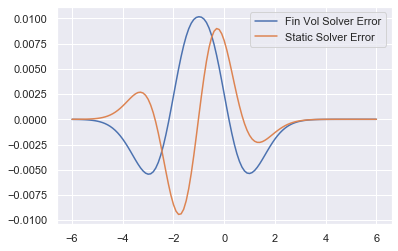

In [21]:
%matplotlib inline
diffusion = 1
timestep = 0.001
T_final = 20
domain_size = 6
spacestep = 0.1
particle_count = 100
herding_function = herd.smooth_G
#Set initial data for Gaussian
mu_init = -1.5
sd_init = 0.5

#Set max/min for indicator
max_init = 0
min_init = -1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data = gaussian #Choose indicator or Gaussian


v, F_diff, moments_diff = hom.FD_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

v, F_vol, moments_vol = hom.FV_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=timestep, T_end=T_final, L=domain_size,
                                      dv=spacestep, G=herding_function)

stat_mu = np.sign(moments_diff[1][0])
stat_dist = stats.norm.pdf(v, stat_mu, np.sqrt(diffusion))
plt.plot(v, stat_dist - F_vol[-1,], label='Fin Vol Solver Error')
plt.plot(v, stat_dist - F_diff[-1,], label='Static Solver Error')

plt.legend()
plt.savefig(savepath+'homkinerror'+'.eps', format='eps', dpi=1000)
plt.show()


In [ ]:
diffusion = 1
timestep = 0.001
T_final = 10
domain_size = 6
spacestep = 0.1
particle_count = 100
herding_function = herd.smooth_G
#Set initial data for Gaussian
mu_init = -1.5
sd_init = 0.5

#Set max/min for indicator
max_init = 0
min_init = -1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data = gaussian #Choose indicator or Gaussian


timesteps = np.logspace(0,-6,10)
spacesteps = np.sqrt(2*diffusion*timesteps)
print(timesteps)
error = np.zeros(len(timesteps))
for idx, t in enumerate(timesteps):
    v, F_diff, moments_diff = hom.FD_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=t, T_end=T_final, L=domain_size,
                                      dv=spacesteps[idx], G=herding_function)

#     v, F_vol, moments_vol = hom.FV_solve_hom_PDE(D=diffusion,
#                                       initial_dist=initial_data['pde'],
#                                       dt=t, T_end=T_final, L=domain_size,
#                                       dv=spacestep, G=herding_function)
#     error[:,idx] = np.array([(spacestep/(2*domain_size))*abs(stat_dist - F_vol[-1,]).sum(),
#                     (spacestep/(2*domain_size))*abs(stat_dist - F_diff[-1,]).sum()])
    stat_mu = np.sign(F_diff[0,].mean())
    stat_dist = stats.norm.pdf(v, stat_mu, np.sqrt(diffusion))

    error[idx] = abs(stat_dist - F_diff[-1,]).sum()
    print(error)

plt.plot(timesteps, error)
#plt.plot(timesteps, error[1,])
plt.show()

In [ ]:
timesteps = np.logspace(-3,-4,5)
spacesteps = [0.1]*5
print(timesteps, spacesteps)
error = np.zeros(len(timesteps))
for idx, t in enumerate(timesteps):
#     v, F_diff, moments_diff = hom.FD_solve_hom_PDE(D=diffusion,
#                                       initial_dist=initial_data['pde'],
#                                       dt=t, T_end=T_final, L=domain_size,
#                                       dv=spacesteps[idx], G=herding_function)

    v, F_vol, moments_vol = hom.FV_solve_hom_PDE(D=diffusion,
                                      initial_dist=initial_data['pde'],
                                      dt=t, T_end=T_final, L=domain_size,
                                      dv=spacesteps[idx], G=herding_function)
#     error[:,idx] = np.array([(spacestep/(2*domain_size))*abs(stat_dist - F_vol[-1,]).sum(),
#                     (spacestep/(2*domain_size))*abs(stat_dist - F_diff[-1,]).sum()])
    stat_mu = np.sign(F_vol[0,].mean())
    stat_dist = stats.norm.pdf(v, stat_mu, np.sqrt(diffusion))

    error[idx] = abs(stat_dist - F_vol[-1,]).sum()
    print(error)

plt.plot(timesteps, error)
#plt.plot(timesteps, error[1,])
plt.show()

## Space Heterogeneous Particle Model


In [ ]:
%matplotlib inline
particle_count = 100
diffusion = 1
initial_data_x = np.pi/2
timestep = 0.01
T_final = 200
herding_function = herd.step_G

#Set initial data for Gaussian
mu_init = -1.5
sd_init = 0.5

#Set max/min for indicator
max_init = 2
min_init = 1

gaussian = {'particle': normal(loc=mu_init, scale=sd_init ,size=particle_count),
            'pde': lambda x: stats.norm.pdf(x, loc=mu_init, scale=sd_init)}

indicator = {'particle': uniform(low=min_init, high=max_init, size=particle_count),
            'pde': lambda x: np.array([int(i>=min_init and i<=max_init) for i in x])} 


initial_data_v = indicator #Choose indicator or Gaussian


t, x, v = het.run_particle_model(particles = particle_count, D=diffusion,
                          initial_dist_x=initial_data_x,
                          initial_dist_v=initial_data_v['particle'],
                          dt=0.01, T_end=200, G=herd.step_G)

In [ ]:
g = sns.jointplot(x.flatten(), v.flatten(), kind="hex", height=7, space=0)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()

hetplt.plot_vel_hist(slice(-1000,-1), t,x,v,ax)
fig.show()

In [ ]:
%matplotlib qt
conv_to_pos  = hetplt.anim_full(t, x, v, framestep=5)